# EDA

In [18]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import lightgbm as lgb

with open("densenet201_gap_features.pkl", "rb") as f:
    data = pickle.load(f)

X = np.array(data['features'])
y = np.array(data['labels'])
image_names = np.array(data['image_names'])

le = LabelEncoder()
y_encoded = le.fit_transform(y)

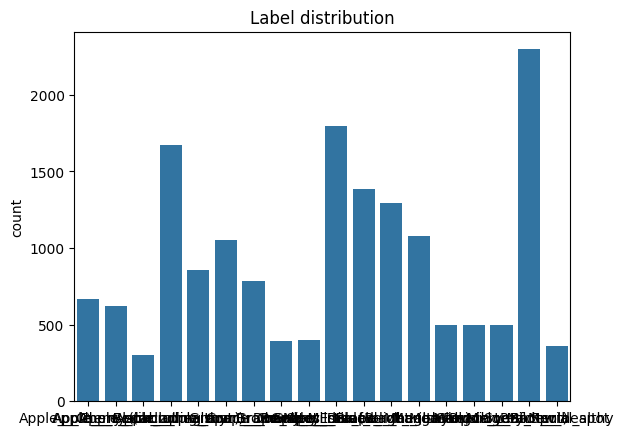

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title("Label distribution")
plt.show()

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)
eigenvalues = pca.explained_variance_
import numpy as np

count_ge_1 = np.sum(eigenvalues >= 1)
total_components = len(eigenvalues)
percentage = 100 * count_ge_1 / total_components

print(f"Số lượng eigenvalue >= 1: {count_ge_1}/{total_components}")
print(f"Tỷ lệ phần trăm: {percentage:.2f}%")


Số lượng eigenvalue >= 1: 202/1920
Tỷ lệ phần trăm: 10.52%


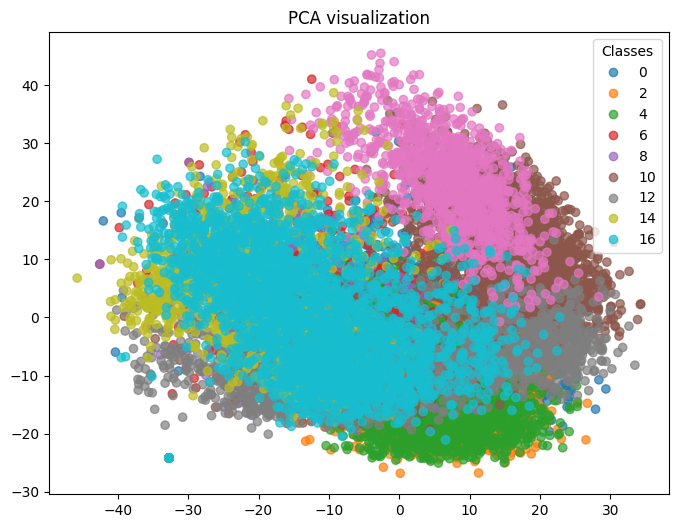

In [22]:
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_encoded, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA visualization")
plt.show()


# Features Selection

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=202)
X_pca = pca.fit_transform(X_scaled)
print("Kích thước ban đầu:", X_scaled.shape)
print("Kích thước sau PCA:", X_pca.shape)

with open("saved_modelsDeepFT/pca.pkl", "wb") as f:
    pickle.dump(pca, f)

Kích thước ban đầu: (16446, 1920)
Kích thước sau PCA: (16446, 202)


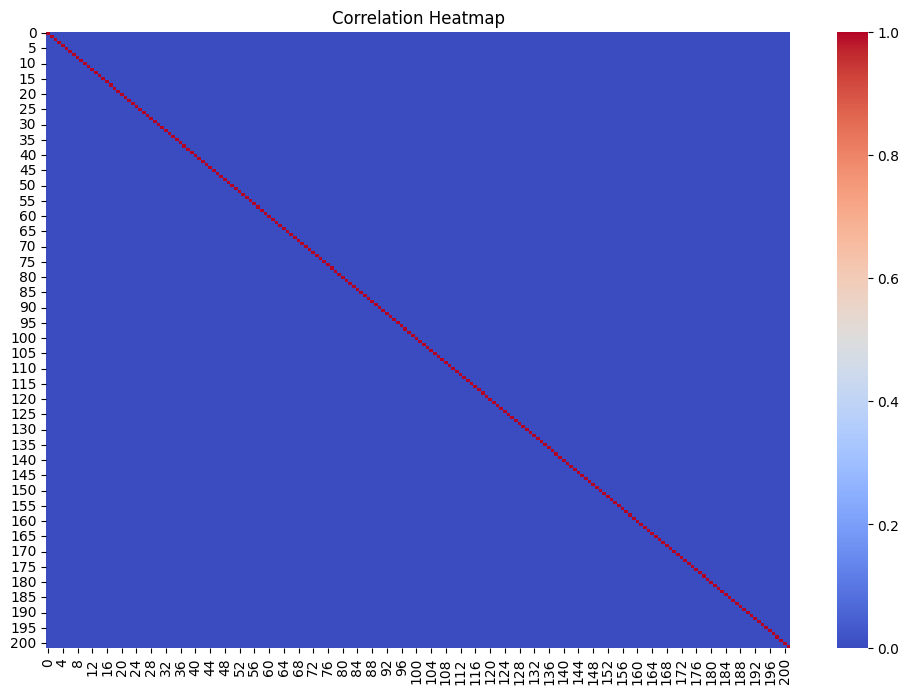

In [24]:
X_pca_df = pd.DataFrame(X_pca)

corr = X_pca_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Training

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [26]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=89, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=11),
    "LightGBM": lgb.LGBMClassifier(n_estimators=88, random_state=42, verbose=-1)
}

os.makedirs("saved_modelsDeepFT", exist_ok=True)
all_results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    cv_scores = cross_val_score(model, X_pca, y_encoded, cv=5, scoring='accuracy')

    all_results.append({
        "Model": name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4),
        "CV_scores(5fold)": round(np.mean(cv_scores), 4)
    })

    model_path = f"saved_modelsDeepFT/{name.replace(' ', '_')}_pca_DenseNet201.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    print(f"Saved model to {model_path}")

df_results = pd.DataFrame(all_results)
df_results.to_csv("model_results_pca_Densenet201.csv", index=False)


Training Logistic Regression...
Saved model to saved_modelsDeepFT/Logistic_Regression_pca_DenseNet201.pkl

Training SVM...
Saved model to saved_modelsDeepFT/SVM_pca_DenseNet201.pkl

Training Random Forest...
Saved model to saved_modelsDeepFT/Random_Forest_pca_DenseNet201.pkl

Training K-Nearest Neighbors...
Saved model to saved_modelsDeepFT/K-Nearest_Neighbors_pca_DenseNet201.pkl

Training LightGBM...


c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.w

Saved model to saved_modelsDeepFT/LightGBM_pca_DenseNet201.pkl


c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [27]:

with open("saved_modelsDeepFT/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("saved_modelsDeepFT/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print("Saved scaler, PCA, and label encoder.")

Saved scaler, PCA, and label encoder.
